# IMU

## Filters

You want to lowpass filter gyros with a 3dB bandwidth between 2-100Hz depending on application.

```matlab
# second order butterworth filter
[A,B,C,D] = butter(2, Wn)
```

where `Wn` is the normalized cutoff frequency.

- $Wn = f_{cut} / f_{nyquist} = 2 f_{cut} / f_{sample} = 0.5$
- `Wn` varies between 0 and 1 (or $f_{nyquist}$)

## `scipy.signal`

| func | description |
|---|---|
| [`freqz`][1] | Compute the frequency response of a digital filter
| [`butter`][2] | Butterworth digital and analog filter design

[1]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.freqz.html#scipy.signal.freqz
[2]: https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html

In [15]:
from scipy import signal
import matplotlib.pyplot as plt
import numpy as np

In [160]:
fc = 25
fs = 100
Wn = fc/(fs/2)
order = 2

# w[Hz], fc[Hz] and fs[Hz] are same units
# [b,a] = signal.butter(order, fc, 'low', fs=fs, analog=False)
[b,a] = signal.butter(order, Wn, 'low')
print(f"B: {b}")
print(f"A: {a}")
w, h = signal.freqz(b, a, fs=fs)

B: [0.29289322 0.58578644 0.29289322]
A: [ 1.00000000e+00 -1.66533454e-16  1.71572875e-01]


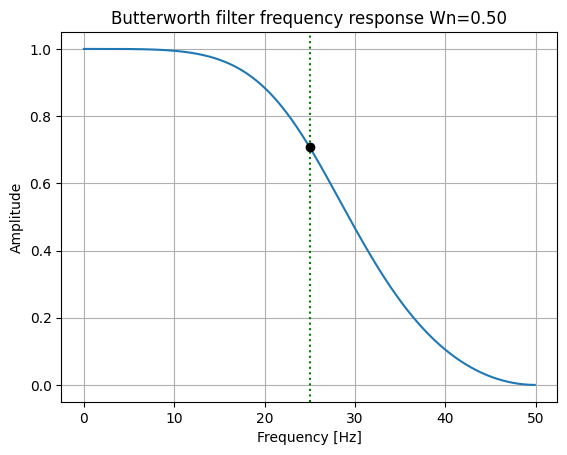

In [161]:
plt.plot(w, np.abs(h))
# plt.xlim(0, np.pi)
plt.title(f'Butterworth filter frequency response Wn={Wn:.2f}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude')
# plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(fc, color='green', ls=':') # cutoff frequency
plt.plot(fc, 0.5*np.sqrt(2), 'ko');    # -3dB

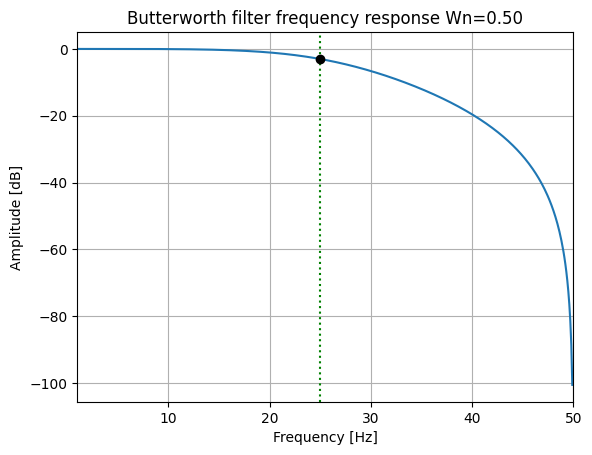

In [162]:
plt.plot(w, 20 * np.log10(np.abs(h)))
plt.xlim(1, 0.5*fs)
plt.title(f'Butterworth filter frequency response Wn={Wn:.2f}')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Amplitude [dB]')
# plt.margins(0, 0.1)
plt.grid(which='both', axis='both')
plt.axvline(fc, color='green', ls=':'); # cutoff frequency
plt.plot(fc, 20*np.log10(0.5*np.sqrt(2)), 'ko'); # -3dB

## Accelerometer

Vector lab [model](https://www.vectornav.com/resources/inertial-navigation-primer/specifications--and--error-budgets/specs-imucal)

$$
\begin{align}
A_{cal} = S M (A_{uncal} - bias) \\
S = diag([S_x S_y S_z]) \\
M = \begin{bmatrix}
    1 & \alpha_1 & \alpha_2 \\
    \alpha_3 & 1 & \alpha_4 \\
    \alpha_5 & \alpha_6 & 1
\end{bmatrix}
\end{align}
$$

Now S and M can be combined like below into one matrix SFCC

Matlab accelerometer [model](https://www.mathworks.com/help/aeroblks/threeaxisaccelerometer.html).

$$
\begin{array} \\
A_{imeas} = A_b + \omega_b \times (\omega_b \times d) + \dot \omega_b \times d - g \\
A_{meas} = A_{imeas} \times A_{SFCC} + A_{bias} + noise
\end{array}
$$

| Variable | Unit | Description
|---|---|---|
| $A_{imeas}$ | g | ideal measurement
| $A_b$ | g | acceleration at the center of gravity (CoG) of the body
| $A_{bias}$ | g | bias terms
| $A_{SFCC}$ | unitless | is the 3x3 matrix, scalling factors on the diagonal, misalignment terms on nondiagonal
| $d$ | m | lever arm is defined as the disctance from the CoG, d = [forward, right, and below CoG]
| $\omega_b$ | rad/sec | body-fixed angular rates
| $\dot \omega_b$ | rad/sec/sec | body-fixed angular accelerations

In [126]:
def imu(a, w, d):
    ai = a+np.cross(w, np.cross(w,d))
    sfcc = np.array([
        [1,0,0],
        [0,1,0],
        [0,0,1]
    ])
    bias = np.array([0,0,0])
    noise = np.array([0,0,0])
    return sfcc @ ai + bias + noise

In [163]:
t = np.pi * np.array(range(100)) / 50
ao = np.array([
    np.sin(t),
    np.cos(t),
    np.zeros(100)
])
ao = ao.T
w = np.array([0,0,1/50])
d = np.array([0.2,0.3,0.1])

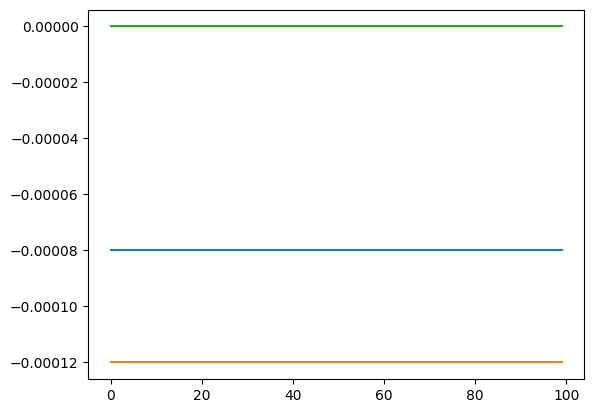

In [165]:
# plt.plot(ao);
a = [imu(aa, w, d) for aa in ao]
plt.plot(a-ao);
# plt.plot(ao);